In [1]:
!apt-get update
!apt-get install -y libgl1-mesa-glx

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]      
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                         
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease   
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 4s (60.3 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgl1-mesa-glx is already the newest version (23.0.4-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 76 not upgraded.


In [6]:
!pip install moviepy
!pip install librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 11.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 11.3 MB/s eta 0:00:0000:0100:01


In [10]:
import json
import cv2
import os
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import librosa
import numpy as np

# JSON 파일 경로 및 비디오 파일 경로
json_file = '/root/AlphaPose/output/dalla_dalla/pose_results/alphapose-results.json'
video_file = '/root/segment-anything-2/data/dalla_dalla.mp4'
output_audio_dir = '/root/AlphaPose/output/dalla_dalla/audio_segments/'

# JSON 파일 로드
with open(json_file, 'r') as f:
    pose_data = json.load(f)

# 비디오 로드
cap = cv2.VideoCapture(video_file)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

print(f'----- Image Info')
print(f'Width: {width}')
print(f'Height: {height}')
print(f'FPS: {fps}')

# 포즈 시각화 함수
def draw_pose(img, keypoints):
    for i in range(0, len(keypoints), 3):
        x = int(keypoints[i])
        y = int(keypoints[i+1])
        conf = keypoints[i+2]
        if conf > 0.1:  # 신뢰 점수 0.1 이상만 표시
            cv2.circle(img, (x, y), 5, (0, 255, 0), -1)  # 관절 표시

# 프레임을 시각화하는 함수
def visualize_frame(frame_idx):
    # 비디오의 해당 프레임으로 이동
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    
    # 프레임 읽기
    ret, frame = cap.read()
    if not ret:
        print(f"프레임 {frame_idx}을(를) 불러오는데 실패했습니다.")
        return
    
    # 현재 프레임에 해당하는 포즈 정보 로드
    frame_data = [item for item in pose_data if item['image_id'] == f'{frame_idx}.jpg']  # 해당 프레임의 ID를 찾음

    # 각 사람의 포즈를 프레임에 시각화
    for person_data in frame_data:
        keypoints = person_data['keypoints']
        draw_pose(frame, keypoints)

    # OpenCV는 BGR 형식을 사용하므로, 이를 RGB 형식으로 변환
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # 주피터 노트북에서 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(frame_rgb)
    plt.axis('off')  # 축을 숨김
    plt.show()

# 비디오에서 15초 단위로 오디오 추출
def extract_audio_segments(video_file, output_dir, segment_duration=15):
    video_clip = VideoFileClip(video_file)
    total_duration = video_clip.duration
    os.makedirs(output_dir, exist_ok=True)

    segment_count = int(total_duration // segment_duration)

    audio_segments = []
    for i in range(segment_count):
        start_time = i * segment_duration
        end_time = (i + 1) * segment_duration
        audio_clip = video_clip.subclip(start_time, end_time)
        audio_file = os.path.join(output_dir, f'segment_{i}.mp3')
        audio_clip.audio.write_audiofile(audio_file)
        audio_segments.append(audio_file)

    return audio_segments

# 포즈 데이터에서 15초 단위로 구간을 나누기
def get_pose_segments(pose_data, fps, segment_duration=15):
    frames_per_segment = int(fps * segment_duration)
    frame_data_map = {}

    for person_data in pose_data:
        frame_id = int(person_data['image_id'].split('.')[0])
        segment_id = frame_id // frames_per_segment
        if segment_id not in frame_data_map:
            frame_data_map[segment_id] = {}  # segment_id에 맞는 새로운 딕셔너리 생성
        if frame_id not in frame_data_map[segment_id]:
            frame_data_map[segment_id][frame_id] = []  # frame_id에 맞는 리스트 생성
        frame_data_map[segment_id][frame_id].append(person_data)  # frame_id에 포즈 데이터 추가

    return frame_data_map

# MMC 계산 함수
def calculate_mmc(frame_data_map, audio_file, fps):
    # 1. 음악 비트 정보 추출
    y, sr = librosa.load(audio_file, sr=None)  # 15초 구간 오디오 파일
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)

    print(f"Extracted Tempo: {tempo}")
    # print(f"Beat Times: {beat_times}")

    # 2. 포즈 변화량 계산 (프레임 간 관절 속도)
    joint_speeds = []

    frame_ids = sorted(frame_data_map.keys())
    for i in range(1, len(frame_ids)):
        prev_frame = frame_data_map[frame_ids[i-1]]
        curr_frame = frame_data_map[frame_ids[i]]

        for prev_person, curr_person in zip(prev_frame, curr_frame):
            # 각 사람의 keypoints 추출
            prev_keypoints = np.array(prev_person['keypoints']).reshape(-1, 3)
            curr_keypoints = np.array(curr_person['keypoints']).reshape(-1, 3)

            # 각 관절의 속도(변화량) 계산
            speeds = np.linalg.norm(curr_keypoints[:, :2] - prev_keypoints[:, :2], axis=1)
            joint_speeds.append(speeds)

    # 3. 프레임에서의 관절 변화 시간을 FPS로 변환
    avg_joint_speeds = np.mean(joint_speeds, axis=0)  # 각 관절의 평균 속도
    frame_times = np.arange(len(avg_joint_speeds)) / fps  # 각 프레임의 시간 값 계산

    # 4. 비트와 관절 변화량 간 상관관계 계산
    # 비트 타임과 가장 가까운 프레임의 관절 속도와 상관관계를 구함
    beat_frame_speeds = []
    for beat_time in beat_times:
        closest_frame_idx = np.argmin(np.abs(frame_times - beat_time))
        beat_frame_speeds.append(avg_joint_speeds[closest_frame_idx])

    # 상관계수 계산 (음악 비트와 관절 변화량 간의 상관관계)
    if len(beat_frame_speeds) > 1:
        mmc_correlation = np.corrcoef(beat_times[:len(beat_frame_speeds)], beat_frame_speeds)[0, 1]
    else:
        mmc_correlation = 0.0

    return mmc_correlation

# 메인 함수: 15초 단위로 오디오와 포즈 데이터를 처리하고 MMC를 계산
def process_video_and_calculate_mmc(video_file, pose_data, fps, segment_duration=15):
    # 오디오 추출
    audio_segments = extract_audio_segments(video_file, output_audio_dir, segment_duration)

    # 포즈 데이터를 15초 단위로 분할
    pose_segments = get_pose_segments(pose_data, fps, segment_duration)

    # 각 15초 구간에 대해 MMC 계산
    for segment_id, audio_file in enumerate(audio_segments):
        if segment_id in pose_segments:
            frame_data_map = pose_segments[segment_id]  # 이 부분을 딕셔너리로 가져옴
            mmc_score = calculate_mmc(frame_data_map, audio_file, fps)
            print(f"Segment {segment_id}: MMC Score = {mmc_score}")

# 실행 예시
process_video_and_calculate_mmc(video_file, pose_data, fps, segment_duration=15)

----- Image Info
Width: 1280
Height: 720
FPS: 60.00020579731023
MoviePy - Writing audio in /root/AlphaPose/output/dalla_dalla/audio_segments/segment_0.mp3


MoviePy - Done.
MoviePy - Writing audio in /root/AlphaPose/output/dalla_dalla/audio_segments/segment_1.mp3


MoviePy - Done.
MoviePy - Writing audio in /root/AlphaPose/output/dalla_dalla/audio_segments/segment_2.mp3


MoviePy - Done.
MoviePy - Writing audio in /root/AlphaPose/output/dalla_dalla/audio_segments/segment_3.mp3


MoviePy - Done.
MoviePy - Writing audio in /root/AlphaPose/output/dalla_dalla/audio_segments/segment_4.mp3


MoviePy - Done.
MoviePy - Writing audio in /root/AlphaPose/output/dalla_dalla/audio_segments/segment_5.mp3


MoviePy - Done.
MoviePy - Writing audio in /root/AlphaPose/output/dalla_dalla/audio_segments/segment_6.mp3


MoviePy - Done.
MoviePy - Writing audio in /root/AlphaPose/output/dalla_dalla/audio_segments/segment_7.mp3


MoviePy - Done.
MoviePy - Writing audio in /root/AlphaPose/output/dalla_dalla/audio_segments/segment_8.mp3


MoviePy - Done.
MoviePy - Writing audio in /root/AlphaPose/output/dalla_dalla/audio_segments/segment_9.mp3


MoviePy - Done.
MoviePy - Writing audio in /root/AlphaPose/output/dalla_dalla/audio_segments/segment_10.mp3


MoviePy - Done.
MoviePy - Writing audio in /root/AlphaPose/output/dalla_dalla/audio_segments/segment_11.mp3


MoviePy - Done.
Extracted Tempo: [126.04801829]
Segment 0: MMC Score = 0.0864584287369959
Extracted Tempo: [126.04801829]
Segment 1: MMC Score = nan
Extracted Tempo: [126.04801829]
Segment 2: MMC Score = -1.1507020058421565e-16
Extracted Tempo: [126.04801829]
Segment 3: MMC Score = -1.3634538856025337e-16
Extracted Tempo: [126.04801829]
Segment 4: MMC Score = nan
Extracted Tempo: [126.04801829]
Segment 5: MMC Score = 1.6150893352083877e-16
Extracted Tempo: [126.04801829]
Segment 6: MMC Score = -4.546131357305448e-16
Extracted Tempo: [126.04801829]
Segment 7: MMC Score = -0.12570119489934836
Extracted Tempo: [126.04801829]
Segment 8: MMC Score = 2.7444420624339946e-17
Extracted Tempo: [126.04801829]
Segment 9: MMC Score = nan
Extracted Tempo: [126.04801829]
Segment 10: MMC Score = 0.18404232798265158
Extracted Tempo: [126.04801829]
Segment 11: MMC Score = nan


In [4]:
# JSON 파일 로드
with open(json_file, 'r') as f:
    pose_data = json.load(f)

# 비디오 로드
cap = cv2.VideoCapture(video_file)

In [5]:
# 포즈 시각화 함수
def draw_pose(img, keypoints):
    for i in range(0, len(keypoints), 3):
        x = int(keypoints[i])
        y = int(keypoints[i+1])
        conf = keypoints[i+2]
        if conf > 0.1:  # 신뢰 점수 0.1 이상만 표시
            cv2.circle(img, (x, y), 5, (0, 255, 0), -1)  # 관절 표시

# 프레임을 시각화하는 함수
def visualize_frame(frame_idx):
    # 비디오의 해당 프레임으로 이동
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    
    # 프레임 읽기
    ret, frame = cap.read()
    if not ret:
        print(f"프레임 {frame_idx}을(를) 불러오는데 실패했습니다.")
        return
    
    # 현재 프레임에 해당하는 포즈 정보 로드
    frame_data = [item for item in pose_data if item['image_id'] == f'{frame_idx}.jpg']  # 해당 프레임의 ID를 찾음

    # 각 사람의 포즈를 프레임에 시각화
    for person_data in frame_data:
        keypoints = person_data['keypoints']
        draw_pose(frame, keypoints)

    # OpenCV는 BGR 형식을 사용하므로, 이를 RGB 형식으로 변환
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # 주피터 노트북에서 시각화
    plt.figure(figsize=(10, 10))
    plt.imshow(frame_rgb)
    plt.axis('off')  # 축을 숨김
    plt.show()

# 비디오 처리 종료 함수 (필요할 때 호출)
def release_video():
    cap.release()

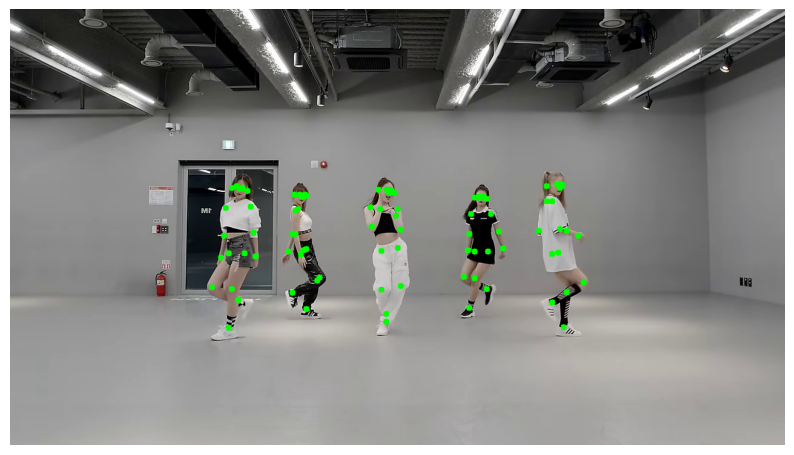

In [10]:
# 시각화 예시
visualize_frame(2000)

In [13]:
# 첫 번째 프레임에 대한 처리
frame_id = 0

frame_data = [item for item in pose_data if item['image_id'] == f'{frame_id}.jpg']

# 첫 번째 프레임의 포즈 데이터 출력
print(f"Frame ID: {frame_id}")
for idx, person_data in enumerate(frame_data):
    print(f"Person {idx+1}:")
    print(f"  - Keypoints: {person_data['keypoints']}")
    print(f"  - Score: {person_data.get('score', 'N/A')}")

Frame ID: 0
Person 1:
  - Keypoints: [635.861328125, 318.3380126953125, 0.9572985172271729, 639.677978515625, 314.5213317871094, 0.9596892595291138, 632.044677734375, 314.5213317871094, 0.9482324123382568, 647.3113403320312, 316.4296569824219, 0.9644280076026917, 628.2279663085938, 316.4296569824219, 0.9488906860351562, 654.9447021484375, 335.5130310058594, 0.8979300260543823, 622.5029907226562, 333.6047058105469, 0.9182261824607849, 658.7613525390625, 360.3214111328125, 0.9134284257888794, 614.86962890625, 356.5047302246094, 0.9191980957984924, 651.1280517578125, 339.3297119140625, 0.9694256782531738, 620.5946655273438, 341.238037109375, 0.8385637998580933, 649.2196655273438, 390.85479736328125, 0.7881226539611816, 626.3196411132812, 390.85479736328125, 0.8419537544250488, 649.2196655273438, 430.92987060546875, 0.9110149145126343, 607.2362670898438, 429.02154541015625, 0.9315633177757263, 645.4030151367188, 474.8216247558594, 0.877105712890625, 616.7779541015625, 472.91326904296875, 0

In [11]:
import json
import cv2
import os

# JSON 파일 경로 및 비디오 파일 경로
json_file = '/root/AlphaPose/output/dalla_dalla/pose_results/alphapose-results.json'
video_file = '/root/segment-anything-2/data/dalla_dalla.mp4'
output_video = '/root/AlphaPose/output/dalla_dalla/dalla_dalla-visualized.mp4'

# JSON 파일 로드
with open(json_file, 'r') as f:
    pose_data = json.load(f)

# 비디오 로드
cap = cv2.VideoCapture(video_file)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

print(f'----- Image Info')
print(f'Width: {width}')
print(f'Height: {height}')
print(f'FPS: {fps}')

# 비디오 저장 설정
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

# 포즈 시각화 함수
def draw_pose(img, keypoints):
    for i in range(0, len(keypoints), 3):
        x = int(keypoints[i])
        y = int(keypoints[i+1])
        conf = keypoints[i+2]
        if conf > 0.1:  # 신뢰 점수 0.1 이상만 표시
            cv2.circle(img, (x, y), 5, (0, 255, 0), -1)  # 관절 표시

# 비디오 프레임에 포즈 오버레이
frame_id = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # 현재 프레임에 해당하는 포즈 정보 로드
    frame_data = [item for item in pose_data if item['image_id'] == f'{frame_id}.jpg']
    
    for person_data in frame_data:
        keypoints = person_data['keypoints']
        draw_pose(frame, keypoints)
    
    # 결과 비디오에 현재 프레임 쓰기
    out.write(frame)
    
    # 프레임 ID 증가
    frame_id += 1

# 비디오 처리 종료
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Done: {output_video}")

----- Image Info
Width: 1280
Height: 720
FPS: 60.00020579731023
Done: /root/AlphaPose/output/dalla_dalla/dalla_dalla-visualized.mp4


In [12]:
# 비디오 저장 설정
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

In [13]:
# 포즈 시각화 함수
def draw_pose(img, keypoints):
    for i in range(0, len(keypoints), 3):
        x = int(keypoints[i])
        y = int(keypoints[i+1])
        conf = keypoints[i+2]
        if conf > 0.1:  # 신뢰 점수 0.1 이상만 표시
            cv2.circle(img, (x, y), 5, (0, 255, 0), -1)  # 관절 표시

In [14]:
# 비디오 로드
cap = cv2.VideoCapture(video_file)
ret, frame = cap.read()  # 첫 번째 프레임 읽기
if not ret:w
    print("첫 번째 프레임을 불러오는데 실패했습니다.")
    cap.release()
    exit()

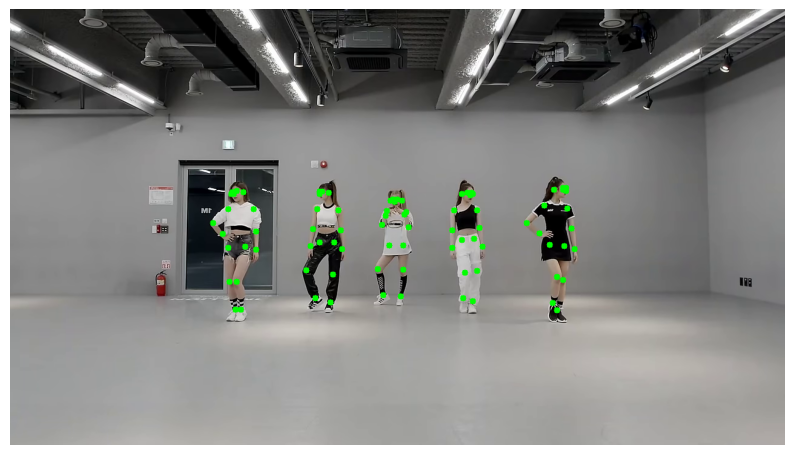

In [15]:
# 첫 번째 프레임에 해당하는 포즈 정보 로드
frame_data = [item for item in pose_data if item['image_id'] == '0.jpg']  # 첫 번째 프레임 ID는 0.jpg

# 각 사람의 포즈를 프레임에 시각화
for person_data in frame_data:
    keypoints = person_data['keypoints']
    draw_pose(frame, keypoints)

# OpenCV는 BGR 형식을 사용하므로, 이를 RGB 형식으로 변환
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# 주피터 노트북에서 시각화
plt.figure(figsize=(10, 10))
plt.imshow(frame_rgb)
plt.axis('off')  # 축을 숨김
plt.show()

In [12]:


# 비디오 프레임에 포즈 오버레이
frame_id = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # 현재 프레임에 해당하는 포즈 정보 로드
    frame_data = [item for item in pose_data if item['image_id'] == f'{frame_id}.jpg']
    
    for person_data in frame_data:
        keypoints = person_data['keypoints']
        draw_pose(frame, keypoints)
    
    # 결과 비디오에 현재 프레임 쓰기
    out.write(frame)
    
    # 프레임 ID 증가
    frame_id += 1

# 비디오 처리 종료
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Done: {output_video}")

Done: /root/AlphaPose/output/dalla_dalla/dalla_dalla-visualized.mp4


Frame ID: 0
Person 1:
  - Keypoints: [635.861328125, 318.3380126953125, 0.9572985172271729, 639.677978515625, 314.5213317871094, 0.9596892595291138, 632.044677734375, 314.5213317871094, 0.9482324123382568, 647.3113403320312, 316.4296569824219, 0.9644280076026917, 628.2279663085938, 316.4296569824219, 0.9488906860351562, 654.9447021484375, 335.5130310058594, 0.8979300260543823, 622.5029907226562, 333.6047058105469, 0.9182261824607849, 658.7613525390625, 360.3214111328125, 0.9134284257888794, 614.86962890625, 356.5047302246094, 0.9191980957984924, 651.1280517578125, 339.3297119140625, 0.9694256782531738, 620.5946655273438, 341.238037109375, 0.8385637998580933, 649.2196655273438, 390.85479736328125, 0.7881226539611816, 626.3196411132812, 390.85479736328125, 0.8419537544250488, 649.2196655273438, 430.92987060546875, 0.9110149145126343, 607.2362670898438, 429.02154541015625, 0.9315633177757263, 645.4030151367188, 474.8216247558594, 0.877105712890625, 616.7779541015625, 472.91326904296875, 0

In [14]:
# 비디오 로드 (다시 열기)
cap = cv2.VideoCapture(video_file)

# 첫 번째 프레임으로 이동
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
ret, frame = cap.read()
if ret:
    for person_data in frame_data:
        keypoints = person_data['keypoints']
        draw_pose(frame, keypoints)

    # 시각화된 이미지 저장
    cv2.imwrite(output_image, frame)
    print(f"첫 번째 프레임에 대한 시각화된 이미지가 저장되었습니다: {output_image}")

    # 시각화된 이미지 표시 (Jupyter Notebook에서 표시)
    from matplotlib import pyplot as plt
    import matplotlib

    # OpenCV는 BGR 포맷을 사용하므로 RGB로 변환
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()
else:
    print("첫 번째 프레임을 읽을 수 없습니다.")

# 비디오 캡쳐 해제
cap.release()

NameError: name 'output_image' is not defined